# Packages Loading

In [159]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, UpSampling2D, BatchNormalization
from keras.models import Sequential, Input, Model
from keras.utils.np_utils import to_categorical
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from keras import backend as K
from keras import optimizers
%matplotlib inline
import numpy as np

# Data Generation functions

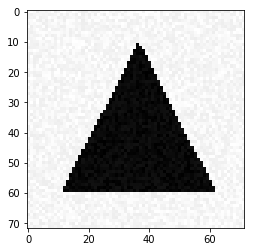

In [179]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    #imdata_noisy = imdata + noise * np.random.random(imdata.size)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata#, imdata_noisy

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    #Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



# 3) Simple classification

### Generation of training data

In [4]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
# One-hot encoding of labels
Y_binary = to_categorical(Y_train)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


### With Stochastic Gradient Descent optimization

In [5]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, input_dim=128, activation='relu'))
model.add(Dense(3, input_dim=128, activation='softmax'))
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
model.fit(X_train,Y_binary,batch_size=32,epochs=10, verbose=1)

Epoch 1/10
300/300 [==============================] - 0s 1ms/step - loss: 1.0045 - acc: 0.5700
Epoch 2/10
300/300 [==============================] - 0s 536us/step - loss: 0.8133 - acc: 0.6600
Epoch 3/10
300/300 [==============================] - 0s 519us/step - loss: 0.6914 - acc: 0.7367
Epoch 4/10
300/300 [==============================] - 0s 434us/step - loss: 0.5190 - acc: 0.8233
Epoch 5/10
300/300 [==============================] - 0s 578us/step - loss: 0.4423 - acc: 0.8733
Epoch 6/10
300/300 [==============================] - 0s 499us/step - loss: 0.3882 - acc: 0.8867
Epoch 7/10
300/300 [==============================] - 0s 529us/step - loss: 0.3273 - acc: 0.9100
Epoch 8/10
300/300 [==============================] - 0s 531us/step - loss: 0.2847 - acc: 0.9367
Epoch 9/10
300/300 [==============================] - 0s 501us/step - loss: 0.2699 - acc: 0.9133
Epoch 10/10
300/300 [==============================] - 0s 485us/step - loss: 0.2475 - acc: 0.9333


### Visualization of the weights

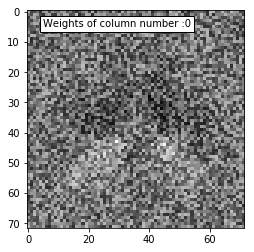

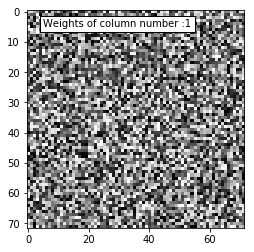

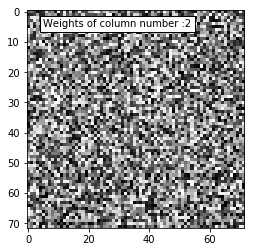

In [34]:
for i in range(0,3):
    weights = model.get_weights()[0][:,i]
    plt.figure()
    plt.text(5, 5,"Weights of column number :"+str(i), bbox={'facecolor': 'white', 'pad': 3})
    plt.imshow(weights.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

### Some Predictions

In [7]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [6]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

### With Adam Optimizer

In [35]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, input_dim=128, activation='relu'))
model.add(Dense(3, input_dim=128, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train,Y_binary,batch_size=32,epochs=10, verbose=1)

Epoch 1/10
300/300 [==============================] - 1s 2ms/step - loss: 1.9919 - acc: 0.3800
Epoch 2/10
300/300 [==============================] - 0s 680us/step - loss: 0.9760 - acc: 0.5233
Epoch 3/10
300/300 [==============================] - 0s 658us/step - loss: 0.7128 - acc: 0.6833
Epoch 4/10
300/300 [==============================] - 0s 759us/step - loss: 0.5293 - acc: 0.7333
Epoch 5/10
300/300 [==============================] - 0s 650us/step - loss: 0.4109 - acc: 0.7967
Epoch 6/10
300/300 [==============================] - 0s 691us/step - loss: 0.3577 - acc: 0.8467
Epoch 7/10
300/300 [==============================] - 0s 780us/step - loss: 0.3123 - acc: 0.8633
Epoch 8/10
300/300 [==============================] - 0s 670us/step - loss: 0.2794 - acc: 0.8900
Epoch 9/10
300/300 [==============================] - 0s 720us/step - loss: 0.2791 - acc: 0.8833
Epoch 10/10
300/300 [==============================] - 0s 661us/step - loss: 0.1893 - acc: 0.9533


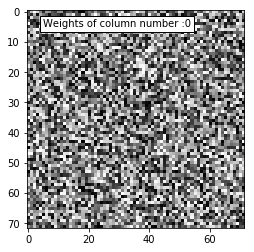

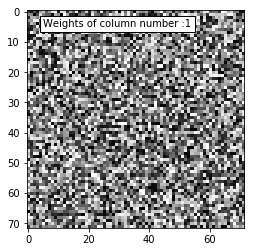

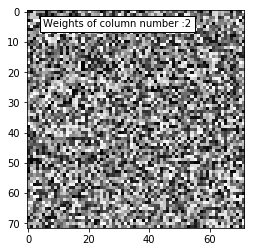

In [36]:
for i in range(0,3):
    weights = model.get_weights()[0][:,i]
    plt.figure()
    plt.text(5, 5,"Weights of column number :"+str(i), bbox={'facecolor': 'white', 'pad': 3})
    plt.imshow(weights.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# A More Difficult Classification Problem

### Generation of training data

In [38]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
# One-hot encoding of labels
Y_binary = to_categorical(Y_train)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [39]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)

In [58]:
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu',input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))
adam = optimizers.Adam(lr=0.001, beta_1=0.95, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model.fit(X_train,Y_binary,batch_size=32,epochs=10, verbose=1)

Epoch 1/10
300/300 [==============================] - 2s 7ms/step - loss: 1.7980 - acc: 0.3767
Epoch 2/10
300/300 [==============================] - 1s 4ms/step - loss: 0.9495 - acc: 0.5700
Epoch 3/10
300/300 [==============================] - 1s 4ms/step - loss: 0.8014 - acc: 0.7267
Epoch 4/10
300/300 [==============================] - 1s 4ms/step - loss: 0.6725 - acc: 0.7600
Epoch 5/10
300/300 [==============================] - 1s 5ms/step - loss: 0.6229 - acc: 0.7533
Epoch 6/10
300/300 [==============================] - 1s 4ms/step - loss: 0.5506 - acc: 0.8100
Epoch 7/10
300/300 [==============================] - 1s 5ms/step - loss: 0.5064 - acc: 0.8067
Epoch 8/10
300/300 [==============================] - 1s 5ms/step - loss: 0.4396 - acc: 0.8733
Epoch 9/10
300/300 [==============================] - 1s 5ms/step - loss: 0.3689 - acc: 0.8733
Epoch 10/10
300/300 [==============================] - 1s 5ms/step - loss: 0.3284 - acc: 0.9133


In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               2367616   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 387       
Total para

In [43]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [59]:
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
Y_binary_test = to_categorical(Y_test)
model.evaluate(X_test, Y_binary_test)

300/300 [==============================] - 1s 2ms/step


[0.7137429078420003, 0.7099999992052713]

# A Regression Problem

### Data generation

In [180]:
[X_train, Y_train] = generate_dataset_regression(3000, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

### Data Pre-processing

##### In the following section, we normalize objective data Y in order to get better performance results. 
##### For each input triangle, we compute its barycenter $B$ and the distance from each vertice $M$ to $B$.
##### We then "normalize" each vertice by replacing it by $\frac{1}{||BM||}(OM - OB) = \frac{1}{||BM||}BM$ as if each data point has its mean withdrawn and has also been divided by its distance to the mean (variance)

In [181]:
dim = Y_train.shape[0]

def order_pts(pts):
    # a function to order points in the trigonometric order and to 
    # computer the barycenter of the triangle
    pts_y = [pts[2*i+1] for i in range(0,int(len(pts)/2))] #impair
    pts_x = [pts[2*i] for i in range(0,int(len(pts)/2))] #pair
    index_x_mostleft = np.argmin(pts_x)
    mostleft = [pts[2*index_x_mostleft],pts[2*index_x_mostleft+1]]
    index_x_mostright = np.argmax(pts_x)
    mostright = [pts[2*index_x_mostright],pts[2*index_x_mostright+1]]
    index_x_middle = 3 - index_x_mostleft - index_x_mostright
    middle= [pts[2*index_x_middle],pts[2*index_x_middle+1]]
    if middle[1] >= mostleft[1]:
        next1 = middle
        next2 = mostleft
    else:
        next1 = mostleft
        next2 = middle
    o_x = (1/3)*sum([elem for elem in pts_x])
    o_y = (1/3)*sum([elem for elem in pts_y])
    center = [o_x,o_y]
    return np.array([mostright, next1, next2, center])

def normalize(tab):
    # a function to normalize vertices of the triangle
    o_x = (1/3)*sum([pts[0] for pts in tab])
    o_y = (1/3)*sum([pts[1] for pts in tab])
    center = [o_x,o_y]
    normalized = []
    distances = []
    for i in range(0,3):
        dist = np.sqrt((tab[i][0]-o_x)**2 + (tab[i][1]-o_y)**2)
        distances.append(dist)
        normalized.append((1/dist)*np.array([tab[i][0] - o_x, tab[i][1] - o_y]))
    normalized.append(center)
    normalized = np.concatenate((normalized, distances), axis=None)
    return np.array(normalized)

# objective data normalization
Y_train_ordered = np.array([order_pts(Y_train[i]) for i in range(0,dim)])
Y_train_normalized = np.array([normalize(Y_train_ordered[i]) for i in range(0,dim)])

# data reshaping before neural network training
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
Y_train_normalized = np.array([Y_train_normalized[i].ravel() for i in range(0,dim)])

##### The neural network is trained to regress 11 values : 6 (vertices coordinates) $+$ 2 (barycenter coordinates) $+$ 3 (distance of each vertice to the barycenter).
##### The 5 added value regressed by the network will be useful for prediction and computing the estimation of the "true" vertices of the test triangle.

In [182]:
model = Sequential()
model.add(Conv2D(16, (6, 6), activation='relu',input_shape=(72,72,1),data_format = "channels_last"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (6, 6), activation='relu',input_shape=(72,72,1),data_format = "channels_last"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu',input_shape=(72,72,1),data_format = "channels_last"))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Conv2D(16, (3, 3), activation='relu',input_shape=(72,72,1),data_format = "channels_last"))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Flatten())
model.add(Dense(352, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(11,  activation='linear'))
adam = optimizers.Adam(lr=0.001, beta_1=0.95, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error',optimizer=adam,metrics=['accuracy'])
model.fit(X_train,Y_train_normalized,batch_size=32,epochs=200, verbose=1)

Epoch 1/200
3000/3000 [==============================] - 24s 8ms/step - loss: 0.1395 - acc: 0.3503
Epoch 2/200
3000/3000 [==============================] - 25s 8ms/step - loss: 0.0877 - acc: 0.5440
Epoch 3/200
3000/3000 [==============================] - 22s 7ms/step - loss: 0.0604 - acc: 0.6257
Epoch 4/200
3000/3000 [==============================] - 25s 8ms/step - loss: 0.0484 - acc: 0.6827
Epoch 5/200
3000/3000 [==============================] - 23s 8ms/step - loss: 0.0422 - acc: 0.7160
Epoch 6/200
3000/3000 [==============================] - 27s 9ms/step - loss: 0.0379 - acc: 0.7410
Epoch 7/200
3000/3000 [==============================] - 24s 8ms/step - loss: 0.0347 - acc: 0.7380
Epoch 8/200
3000/3000 [==============================] - 28s 9ms/step - loss: 0.0336 - acc: 0.7530
Epoch 9/200
3000/3000 [==============================] - 24s 8ms/step - loss: 0.0308 - acc: 0.7610
Epoch 10/200
3000/3000 [==============================] - 23s 8ms/step - loss: 0.0283 - acc: 0.7730
Epoch 11/

3000/3000 [==============================] - 23s 8ms/step - loss: 0.0067 - acc: 0.8450
Epoch 83/200
3000/3000 [==============================] - 22s 7ms/step - loss: 0.0066 - acc: 0.8547
Epoch 84/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0065 - acc: 0.8637
Epoch 85/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0065 - acc: 0.8417
Epoch 86/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0067 - acc: 0.8420
Epoch 87/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0064 - acc: 0.8437
Epoch 88/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0064 - acc: 0.8453
Epoch 89/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0066 - acc: 0.8543
Epoch 90/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0065 - acc: 0.8497
Epoch 91/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0064 - acc: 0.8527
Epoch 92/200


3000/3000 [==============================] - 21s 7ms/step - loss: 0.0055 - acc: 0.8563
Epoch 164/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0055 - acc: 0.8527
Epoch 165/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0054 - acc: 0.8693
Epoch 166/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0056 - acc: 0.8643
Epoch 167/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0053 - acc: 0.8603
Epoch 168/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0055 - acc: 0.8540
Epoch 169/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0055 - acc: 0.8730
Epoch 170/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0056 - acc: 0.8587
Epoch 171/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0057 - acc: 0.8593
Epoch 172/200
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0054 - acc: 0.8613
Epoc

In [183]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 67, 67, 16)        592       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 33, 33, 16)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 28, 28, 16)        9232      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 12, 12, 16)        2320      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 10, 10, 16)        2320      
__________

In [184]:
# test data generation
[X_test, Y_test] = generate_test_set_regression()

# prediction
X_test = X_test.reshape(X_test.shape[0], 72, 72,1)
Y_pred = model.predict(X_test)
X_test = X_test.reshape(300, 5184)

# test data pre-processing
Y_test_ordered = np.array([order_pts(Y_test[i]) for i in range(0,Y_test.shape[0])])
Y_test_normalized = np.array([normalize(Y_test_ordered[i]) for i in range(0,Y_test.shape[0])])

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [185]:
def center(tab):
    # a function to compute the estimation of the "real" values of the vertices 
    # given the estimates of the reduced values, the estimates of barycenter coordinates 
    # and the estimates of the distances from the estimated barycenter
    ox = tab[-5]
    oy = tab[-4]
    distances = tab[-3:]
    pts_x = []
    pts_y = []
    for i in range(0,3):
        pts_x.append(tab[2*i]*distances[i] + ox) #pair
        pts_y.append(tab[2*i+1]*distances[i] + oy) #impair
    result = []
    for i in range(0,3):
        result.append(pts_x[i])
        result.append(pts_y[i])
    return result

# computing predictions
Y_pred = np.array([center(Y_pred[i]) for i in range(0,Y_test.shape[0])])

### Visualization of results

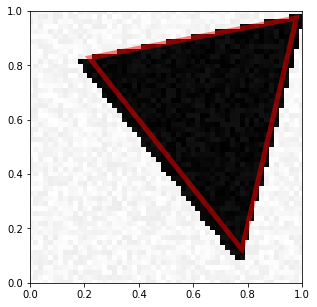

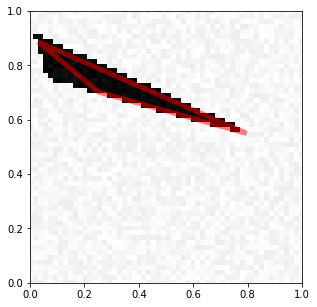

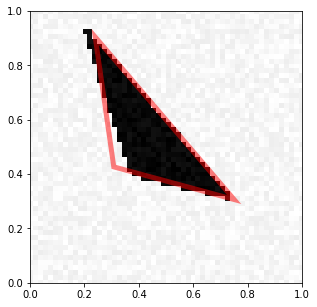

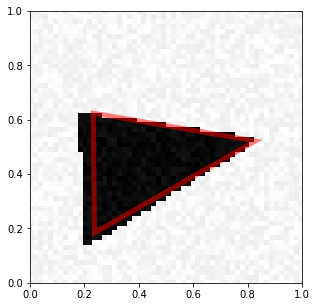

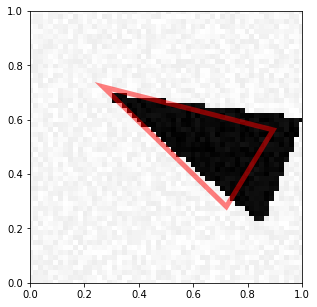

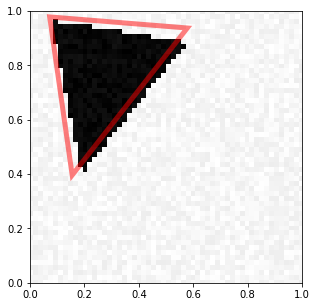

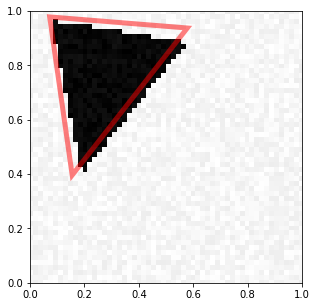

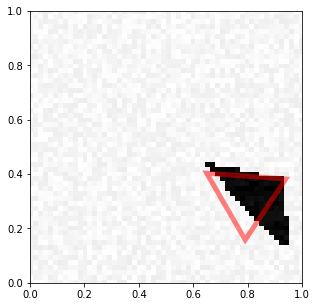

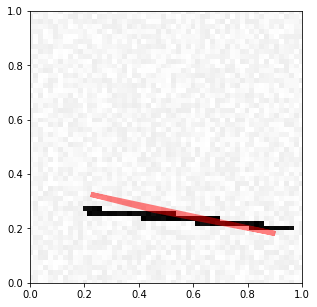

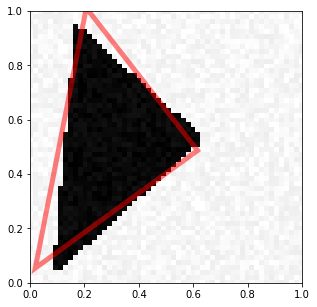

In [187]:
randint = np.random.randint(300, size=10)
for i in randint:
    visualize_prediction(X_test[i], Y_pred[i])

# Image Denoising with Convolutional Autoencoders

In [190]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing_bis(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noisy = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata, imdata_noisy

def generate_a_rectangle_bis(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_bis(figsize, U, V, noise)


def generate_a_disk_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_bis(figsize, U, V, noise)

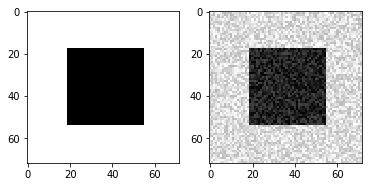

In [191]:
# a data sample to compare noisy and non-noisy images
data = generate_a_rectangle_bis(100)
im = data[0]
im_noisy = data[1]
f, ax = plt.subplots(1,2)
ax[0].imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[1].imshow(im_noisy.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

### Denoising on a particular shape

In [192]:
def generate_dataset_rectangle_denoiser(nb_samples, noise):
    # Getting im_size:
    im_size = generate_a_rectangle(noise)[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = [generate_a_rectangle(noise)[1],generate_a_rectangle(noise)[0]]
    return [X, Y]

In [169]:
[X_train,Y_train] = generate_dataset_rectangle_denoiser(1000, 100)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [170]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
Y_train = Y_train.reshape(Y_train.shape[0], 72, 72, 1)

In [171]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(72,72,1),padding='same',strides=(1,1),data_format = "channels_last"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(72,72,1),padding='same',strides=(1,1),data_format = "channels_last"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(72,72,1),padding='same',strides=(1,1),data_format = "channels_last"))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(72,72,1),padding='same',strides=(1,1),data_format = "channels_last"))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='sigmoid',input_shape=(72,72,1),padding='same',strides=(1,1),data_format = "channels_last"))
model.add(BatchNormalization())
adam = optimizers.Adam(lr=0.001, beta_1=0.95, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam)
model.fit(X_train,Y_train,batch_size=32,epochs=200, verbose=1)

Epoch 1/200
1000/1000 [==============================] - 34s 34ms/step - loss: -75.7540
Epoch 2/200
1000/1000 [==============================] - 37s 37ms/step - loss: -483.4715
Epoch 3/200
1000/1000 [==============================] - 32s 32ms/step - loss: -546.2548
Epoch 4/200
1000/1000 [==============================] - 31s 31ms/step - loss: -765.1635
Epoch 5/200
1000/1000 [==============================] - 31s 31ms/step - loss: -634.2295
Epoch 6/200
1000/1000 [==============================] - 31s 31ms/step - loss: -831.4909
Epoch 7/200
1000/1000 [==============================] - 30s 30ms/step - loss: -961.7888
Epoch 8/200
1000/1000 [==============================] - 31s 31ms/step - loss: -970.4977
Epoch 9/200
1000/1000 [==============================] - 32s 32ms/step - loss: -948.6845
Epoch 10/200
1000/1000 [==============================] - 31s 31ms/step - loss: -1073.3204
Epoch 11/200
1000/1000 [==============================] - 31s 31ms/step - loss: -1121.4680
Epoch 12/200
1000/

1000/1000 [==============================] - 31s 31ms/step - loss: -2230.4364
Epoch 92/200
1000/1000 [==============================] - 30s 30ms/step - loss: -2239.9901
Epoch 93/200
1000/1000 [==============================] - 31s 31ms/step - loss: -2250.0765
Epoch 94/200
1000/1000 [==============================] - 31s 31ms/step - loss: -2246.7541
Epoch 95/200
1000/1000 [==============================] - 31s 31ms/step - loss: -2273.6684
Epoch 96/200
1000/1000 [==============================] - 31s 31ms/step - loss: -2278.2401
Epoch 97/200
1000/1000 [==============================] - 31s 31ms/step - loss: -2285.8101
Epoch 98/200
1000/1000 [==============================] - 31s 31ms/step - loss: -2282.8667
Epoch 99/200
1000/1000 [==============================] - 31s 31ms/step - loss: -2297.2352
Epoch 100/200
1000/1000 [==============================] - 32s 32ms/step - loss: -2250.6946
Epoch 101/200
1000/1000 [==============================] - 31s 31ms/step - loss: -2325.7689
Epoch 102/

1000/1000 [==============================] - 31s 31ms/step - loss: -2554.2598
Epoch 181/200
1000/1000 [==============================] - 31s 31ms/step - loss: -2560.9901
Epoch 182/200
1000/1000 [==============================] - 30s 30ms/step - loss: -2546.0342
Epoch 183/200
1000/1000 [==============================] - 30s 30ms/step - loss: -2569.3800
Epoch 184/200
1000/1000 [==============================] - 30s 30ms/step - loss: -2517.0536
Epoch 185/200
1000/1000 [==============================] - 31s 31ms/step - loss: -2571.2382
Epoch 186/200
1000/1000 [==============================] - 31s 31ms/step - loss: -2507.8860
Epoch 187/200
1000/1000 [==============================] - 30s 30ms/step - loss: -2471.5520
Epoch 188/200
1000/1000 [==============================] - 31s 31ms/step - loss: -2478.7703
Epoch 189/200
1000/1000 [==============================] - 31s 31ms/step - loss: -2444.9268
Epoch 190/200
1000/1000 [==============================] - 31s 31ms/step - loss: -2445.6550
Ep

### Testing the Denoiser

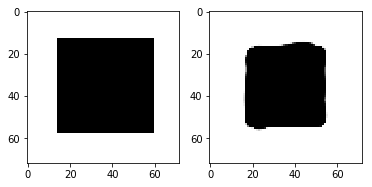

In [178]:
data = generate_a_rectangle(100)
im = data[0]
im_noisy = data[1]
im_noisy = im_noisy.reshape(1,72, 72,1)
Y_pred = model.predict(im_noisy)

f, ax = plt.subplots(1,2)
ax[0].imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[1].imshow(Y_pred.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')